# 1. Most downloaded otome games in 2025 Q1, data from [Sensortower](sensortower.com[https://sensortower.com/blog/2025-q1-unified-top-5-otome%20games-units-us-60789073241bc16eb88c6e7f])

**1** [Love and deepspace](https://app.sensortower.com/overview/654319170b276e064b329296?country=US)  
**2** [Dorian: Interactive Dramas Hub](https://app.sensortower.com/overview/60038cf5c86cbe76cd846cfa?country=US)  
**3** [Boba Story](https://app.sensortower.com/overview/610f77279c96214ec4fe1388?country=US)  
**4** [Anime Dating Sim: Steamy Waifu](https://app.sensortower.com/overview/647533dd5d2a176ec9b3b678?country=US)  
**5** [NU: Carnival - Bliss](https://app.sensortower.com/overview/6582614bb759a80dbc1cbcc4?country=US)



# 2. Most loved Anime characters, results from [MyAnimeList](https://myanimelist.net/character.php)

In [5]:
from bs4 import BeautifulSoup
import pandas as pd
import requests
import time

In [144]:
base_url = "https://myanimelist.net/character.php?limit="
headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) " +
                  "AppleWebKit/537.36 (KHTML, like Gecko) " +
                  "Chrome/58.0.3029.110 Safari/537.3"
}

all_characters = []

for offset in range(0, 1000, 50):
    page_url = f"{base_url}{offset}"
    response = requests.get(page_url, headers=headers)
    time.sleep(3)
    soup = BeautifulSoup(response.text, "html.parser")
    rows = soup.find_all("tr", class_="ranking-list")
    
    if not rows:
        print(f"⚠️ No characters found at offset {offset} — possible block or page layout change.")
        break
    
    for roles in rows:
        rank = roles.find("td", class_="rank").text.strip()
        name = roles.find("td", class_="people").text.strip()
        anime = roles.find("td", class_="animeography").text.strip()
        favorites = roles.find("td", class_="favorites").text.strip().replace(",", "")
        url = roles.find("a")["href"]
        all_characters.append({
            "rank": rank,
            "name": name,
            "anime": anime,
            "favorites": int(favorites),
            "url": url
        })
    print(f"{len(all_characters)} characters scraped")  # use len(all_characters)!
    time.sleep(3)

print(f"top {len(all_characters)} saved")


50 characters scraped
100 characters scraped
150 characters scraped
200 characters scraped
250 characters scraped
300 characters scraped
350 characters scraped
400 characters scraped
450 characters scraped
500 characters scraped
550 characters scraped
600 characters scraped
650 characters scraped
700 characters scraped
750 characters scraped
800 characters scraped
850 characters scraped
900 characters scraped
950 characters scraped
1000 characters scraped
top 1000 saved


In [146]:
df = data = pd.DataFrame(all_characters)
df.to_csv("top_1000_mal_characters_scraped.csv", index=False)
data = pd.read_csv("top_1000_mal_characters_scraped.csv")
data.head()

,rank,name,anime,favorites,url
0,1,"Lamperouge, Lelouch(ルルーシュ・ランペルージ)",Code Geass: Hangyaku no LelouchCode Geass: Han...,173552,https://myanimelist.net/character/417/Lelouch_...
1,2,"Monkey D., Luffy(モンキー・D・ルフィ)",One PieceOne Piece Movie 01One Piece Movie 02:...,143840,https://myanimelist.net/character/40/Luffy_Mon...
2,3,Levi(リヴァイ),Shingeki no Kyojin: Kuinaki SentakuShingeki no...,143364,https://myanimelist.net/character/45627/Levi
3,4,"Lawliet, L(エル ローライト)",Death NoteDeath Note: Rewrite,128375,https://myanimelist.net/character/71/L_Lawliet
4,5,"Roronoa, Zoro(ロロノア・ゾロ)",One PieceOne Piece Movie 01One Piece Movie 02:...,113243,https://myanimelist.net/character/62/Zoro_Roronoa


### scrape individual pages

In [9]:
from playwright.async_api import async_playwright
playwright = await async_playwright().start()
browser = await playwright.chromium.launch(headless=False)
page = await browser.new_page()

In [10]:
import requests
from bs4 import BeautifulSoup
import nest_asyncio
import asyncio

async def extract_content(url):
    try:

        await page.goto(url)
        html = await page.content()
        soup = BeautifulSoup(html, 'html.parser')
        
        normal_header = soup.find('h2', class_='normal_header')
        if not normal_header:
            return "Normal header not found."
        
        content = []
        current = normal_header.next_sibling
        
        while current:
            if current.name == 'div' and 'spoiler' in current.get('class', []):
                break  # Stop at the first spoiler
            if isinstance(current, str):
                content.append(current.strip())
            elif current.name in ['br']:
                content.append('\n')  # Handle line breaks
            elif current.name:
                # Extract text from other tags (e.g., <b>, <a>)
                content.append(current.get_text(strip=True))
            current = current.next_sibling
        
        # Combine and clean the extracted text
        extracted_text = ' '.join(content).replace('\n\n', '\n').strip()
        return extracted_text
    
    except Exception as e:
        return f"Error processing {url}: {str(e)}"

In [152]:
urls = data['url']
descriptions = []
nest_asyncio.apply()
for url in urls:
    result = await extract_content(url)
    time.sleep(2)
    descriptions.append(result)

In [155]:
d = pd.DataFrame(descriptions, columns=['description'])
merged = pd.concat([data, d], axis=1)

In [173]:
def extract_info(text):
    info = {
        "Age": None,
        "Birthday": None,
        "Nationality": None,
        "Height": None,
        "Occupation": None
    }
    for line in text.split("\n"):
        line = line.strip()
        if line.startswith("Age:"):
            info["Age"] = line.replace("Age:", "").strip()
        elif line.startswith("Birthdate:"):
            info["Birthday"] = line.replace("Birthdate:", "").strip()
        elif line.startswith("Nationality:"):
            info["Nationality"] = line.replace("Nationality:", "").strip()
        elif line.startswith("Height:"):
            info["Height"] = line.replace("Height:", "").strip()
        elif line.startswith("Occupation:"):
            info["Occupation"] = line.replace("Occupation:", "").strip()
    return pd.Series(info)

# Apply the function row by row and expand to new columns
merged[["Age", "Birthday", "Nationality", "Height", "Occupation"]] = merged["description"].apply(extract_info)


### Get the image

In [15]:
async def extract_image(url):
    try:

        await page.goto(url)
        html = await page.content()
        soup = BeautifulSoup(html, 'html.parser')
        
        # Find the image
        image = soup.find("div", id="content").find('td').find('img')['src']
        return image
    except Exception as e:
        return f"Error processing {url}: {str(e)}"

In [178]:
urls = data['url']
images = []
nest_asyncio.apply()
for url in urls:
    result = await extract_image(url)
    time.sleep(2)
    images.append(result)

In [179]:
images1 = pd.DataFrame(images, columns=['image'])
merged = pd.concat([merged, images1], axis=1)

In [6]:
merged.to_csv('merged.csv',index = False)
merged = pd.read_csv('merged.csv')
merged.head()

,rank,name,anime,favorites,url,description,image,Age,Birthday,Nationality,Height,Occupation,image.1
0,1,"Lamperouge, Lelouch(ルルーシュ・ランペルージ)",Code Geass: Hangyaku no LelouchCode Geass: Han...,173552,https://myanimelist.net/character/417/Lelouch_...,"Age: 17 (first season), 18 (second season) \n ...",NaN,"17 (first season), 18 (second season)","December 5, 1999 a.t.b. (Sagittarius)",Britannia,"178 cm (5'10"")","Student, Terrorist, Knightmare Pilot, Politici...",Error processing https://myanimelist.net/chara...
1,2,"Monkey D., Luffy(モンキー・D・ルフィ)",One PieceOne Piece Movie 01One Piece Movie 02:...,143840,https://myanimelist.net/character/40/Luffy_Mon...,"Age: 17; 19 \n Birthdate: May 5, Taurus \n Hei...",NaN,17; 19,"May 5, Taurus",NaN,172 cm; 174 cm,NaN,https://cdn.myanimelist.net/images/characters/...
2,3,Levi(リヴァイ),Shingeki no Kyojin: Kuinaki SentakuShingeki no...,143364,https://myanimelist.net/character/45627/Levi,"Birthday: December 25 \n Height: 160 cm (5'3"")...",NaN,NaN,NaN,NaN,"160 cm (5'3"")",NaN,https://cdn.myanimelist.net/images/characters/...
3,4,"Lawliet, L(エル ローライト)",Death NoteDeath Note: Rewrite,128375,https://myanimelist.net/character/71/L_Lawliet,"Birthday: October 31, 1979 (1982 in anime) \n ...",NaN,NaN,NaN,NaN,"179 cm (5'10"")",NaN,Error processing https://myanimelist.net/chara...
4,5,"Roronoa, Zoro(ロロノア・ゾロ)",One PieceOne Piece Movie 01One Piece Movie 02:...,113243,https://myanimelist.net/character/62/Zoro_Roronoa,Error processing https://myanimelist.net/chara...,NaN,NaN,NaN,NaN,NaN,NaN,https://cdn.myanimelist.net/images/characters/...


## Add another 500 character to make sure to escerpt the characters who has more than 1000 votes

In [7]:
base_url = "https://myanimelist.net/character.php?limit="
headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) " +
                  "AppleWebKit/537.36 (KHTML, like Gecko) " +
                  "Chrome/58.0.3029.110 Safari/537.3"
}

additional_characters = []

for offset in range(1000, 1500, 50):
    page_url = f"{base_url}{offset}"
    response = requests.get(page_url, headers=headers)
    time.sleep(3)
    soup = BeautifulSoup(response.text, "html.parser")
    rows = soup.find_all("tr", class_="ranking-list")
    
    if not rows:
        print(f"⚠️ No characters found at offset {offset} — possible block or page layout change.")
        break
    
    for roles in rows:
        rank = roles.find("td", class_="rank").text.strip()
        name = roles.find("td", class_="people").text.strip()
        anime = roles.find("td", class_="animeography").text.strip()
        favorites = roles.find("td", class_="favorites").text.strip().replace(",", "")
        url = roles.find("a")["href"]
        additional_characters.append({
            "rank": rank,
            "name": name,
            "anime": anime,
            "favorites": int(favorites),
            "url": url
        })
    print(f"{len(additional_characters)} characters scraped")  # use len(all_characters)!
    time.sleep(3)

print(f"top {len(additional_characters)} saved")


50 characters scraped
100 characters scraped
150 characters scraped
200 characters scraped
250 characters scraped
300 characters scraped
350 characters scraped
400 characters scraped
450 characters scraped
500 characters scraped
top 500 saved


In [8]:
df = data = pd.DataFrame(additional_characters)
df.to_csv("additional_characters_scraped.csv", index=False)
data = pd.read_csv("additional_characters_scraped.csv")
data.head()

,rank,name,anime,favorites,url
0,1001,"Azazel, Amelie(アザゼル・アメリ)",Mairimashita! Iruma-kunMairimashita! Iruma-kun...,1802,https://myanimelist.net/character/154518/Ameli...
1,1002,"Ishida, Uryuu(石田 雨竜)",BleachBleach Movie 4: Jigoku-henBleach: Sennen...,1801,https://myanimelist.net/character/564/Uryuu_Is...
2,1003,"Dracule, Mihawk(ジュラキュール・ミホーク)",One PieceOne Piece Film: Strong World Episode ...,1800,https://myanimelist.net/character/2064/Mihawk_...
3,1004,"Speeddraw, Fremy(フレミー・スピッドロウ)",Rokka no YuushaRokka no Yuusha Picture Drama,1799,https://myanimelist.net/character/88577/Fremy_...
4,1005,"Marvell, Wendy(ウェンディ・マーベル)",Fairy TailFairy Tail OVAFairy Tail Movie 1: Ho...,1793,https://myanimelist.net/character/28886/Wendy_...


In [11]:
urls = data['url']
descriptions = []
nest_asyncio.apply()
for url in urls:
    result = await extract_content(url)
    time.sleep(2)
    descriptions.append(result)

In [12]:
d = pd.DataFrame(descriptions, columns=['description'])
additional_merged = pd.concat([data, d], axis=1)
additional_merged = pd.read_csv('additional_merged.csv')
additional_merged.head()

,rank,name,anime,favorites,url,description
0,1001,"Azazel, Amelie(アザゼル・アメリ)",Mairimashita! Iruma-kunMairimashita! Iruma-kun...,1802,https://myanimelist.net/character/154518/Ameli...,Gender: female \n Birthday: March 13th \n Age:...
1,1002,"Ishida, Uryuu(石田 雨竜)",BleachBleach Movie 4: Jigoku-henBleach: Sennen...,1801,https://myanimelist.net/character/564/Uryuu_Is...,Age: 15 (formerly) – 17 \n Birthday: November ...
2,1003,"Dracule, Mihawk(ジュラキュール・ミホーク)",One PieceOne Piece Film: Strong World Episode ...,1800,https://myanimelist.net/character/2064/Mihawk_...,Age: 41; 43 \n Birthday: March 9 \n Height: 19...
3,1004,"Speeddraw, Fremy(フレミー・スピッドロウ)",Rokka no YuushaRokka no Yuusha Picture Drama,1799,https://myanimelist.net/character/88577/Fremy_...,Fremy has the appearance of a frail girl with ...
4,1005,"Marvell, Wendy(ウェンディ・マーベル)",Fairy TailFairy Tail OVAFairy Tail Movie 1: Ho...,1793,https://myanimelist.net/character/28886/Wendy_...,Age: 12-16 \n Occupation: Mage \n Affiliation:...


In [13]:
def extract_info(text):
    info = {
        "Age": None,
        "Birthday": None,
        "Nationality": None,
        "Height": None,
        "Occupation": None
    }
    for line in text.split("\n"):
        line = line.strip()
        if line.startswith("Age:"):
            info["Age"] = line.replace("Age:", "").strip()
        elif line.startswith("Birthdate:"):
            info["Birthday"] = line.replace("Birthdate:", "").strip()
        elif line.startswith("Nationality:"):
            info["Nationality"] = line.replace("Nationality:", "").strip()
        elif line.startswith("Height:"):
            info["Height"] = line.replace("Height:", "").strip()
        elif line.startswith("Occupation:"):
            info["Occupation"] = line.replace("Occupation:", "").strip()
    return pd.Series(info)

# Apply the function row by row and expand to new columns
additional_merged[["Age", "Birthday", "Nationality", "Height", "Occupation"]] = additional_merged["description"].apply(extract_info)


In [19]:
additional_merged.head()

,rank,name,anime,favorites,url,description,Age,Birthday,Nationality,Height,Occupation,image
0,1001,"Azazel, Amelie(アザゼル・アメリ)",Mairimashita! Iruma-kunMairimashita! Iruma-kun...,1802,https://myanimelist.net/character/154518/Ameli...,Gender: female \n Birthday: March 13th \n Age:...,17,None,None,"1,90 cm",None,https://cdn.myanimelist.net/images/characters/...
1,1002,"Ishida, Uryuu(石田 雨竜)",BleachBleach Movie 4: Jigoku-henBleach: Sennen...,1801,https://myanimelist.net/character/564/Uryuu_Is...,Age: 15 (formerly) – 17 \n Birthday: November ...,15 (formerly) – 17,None,None,171 (formerly) – 177 cm,"High School Student, Quincy",https://cdn.myanimelist.net/images/characters/...
2,1003,"Dracule, Mihawk(ジュラキュール・ミホーク)",One PieceOne Piece Film: Strong World Episode ...,1800,https://myanimelist.net/character/2064/Mihawk_...,Age: 41; 43 \n Birthday: March 9 \n Height: 19...,41; 43,None,None,"198cm (6'6"")",None,https://cdn.myanimelist.net/images/characters/...
3,1004,"Speeddraw, Fremy(フレミー・スピッドロウ)",Rokka no YuushaRokka no Yuusha Picture Drama,1799,https://myanimelist.net/character/88577/Fremy_...,Fremy has the appearance of a frail girl with ...,None,None,None,None,None,Error processing https://myanimelist.net/chara...
4,1005,"Marvell, Wendy(ウェンディ・マーベル)",Fairy TailFairy Tail OVAFairy Tail Movie 1: Ho...,1793,https://myanimelist.net/character/28886/Wendy_...,Age: 12-16 \n Occupation: Mage \n Affiliation:...,12-16,None,None,None,Mage,https://cdn.myanimelist.net/images/characters/...


In [18]:
urls = additional_merged['url']
images = []
nest_asyncio.apply()
for url in urls:
    result = await extract_image(url)
    time.sleep(2)
    images.append(result)

images1 = pd.DataFrame(images, columns=['image'])
additional_merged = pd.concat([additional_merged, images1], axis=1)

In [20]:
additional_merged.to_csv('additional_merged.csv',index = False)

In [28]:
merged = pd.read_csv('merged.csv')
merged.drop(columns=['image'], inplace=True)

In [30]:
merged = merged.rename(columns={'image.1': 'image'})

In [32]:
final = pd.concat([merged, additional_merged], axis=0)
final.to_csv('final.csv',index = False)

In [33]:
final.head()

,rank,name,anime,favorites,url,description,Age,Birthday,Nationality,Height,Occupation,image
0,1,"Lamperouge, Lelouch(ルルーシュ・ランペルージ)",Code Geass: Hangyaku no LelouchCode Geass: Han...,173552,https://myanimelist.net/character/417/Lelouch_...,"Age: 17 (first season), 18 (second season) \n ...","17 (first season), 18 (second season)","December 5, 1999 a.t.b. (Sagittarius)",Britannia,"178 cm (5'10"")","Student, Terrorist, Knightmare Pilot, Politici...",Error processing https://myanimelist.net/chara...
1,2,"Monkey D., Luffy(モンキー・D・ルフィ)",One PieceOne Piece Movie 01One Piece Movie 02:...,143840,https://myanimelist.net/character/40/Luffy_Mon...,"Age: 17; 19 \n Birthdate: May 5, Taurus \n Hei...",17; 19,"May 5, Taurus",NaN,172 cm; 174 cm,NaN,https://cdn.myanimelist.net/images/characters/...
2,3,Levi(リヴァイ),Shingeki no Kyojin: Kuinaki SentakuShingeki no...,143364,https://myanimelist.net/character/45627/Levi,"Birthday: December 25 \n Height: 160 cm (5'3"")...",NaN,NaN,NaN,"160 cm (5'3"")",NaN,https://cdn.myanimelist.net/images/characters/...
3,4,"Lawliet, L(エル ローライト)",Death NoteDeath Note: Rewrite,128375,https://myanimelist.net/character/71/L_Lawliet,"Birthday: October 31, 1979 (1982 in anime) \n ...",NaN,NaN,NaN,"179 cm (5'10"")",NaN,Error processing https://myanimelist.net/chara...
4,5,"Roronoa, Zoro(ロロノア・ゾロ)",One PieceOne Piece Movie 01One Piece Movie 02:...,113243,https://myanimelist.net/character/62/Zoro_Roronoa,Error processing https://myanimelist.net/chara...,NaN,NaN,NaN,NaN,NaN,https://cdn.myanimelist.net/images/characters/...


## Find the gender 

In [36]:
def detect_gender(desc):
    if pd.isnull(desc):
        return 'unknown'
    
    desc = str(desc).lower()
    female_keywords = ['she', 'her', 'woman', 'girl', 'female', 'lady']
    male_keywords = ['he', 'him', 'man', 'boy', 'male', 'gentleman']
    
    female_score = sum(word in desc for word in female_keywords)
    male_score = sum(word in desc for word in male_keywords)

    if female_score > male_score:
        return 'female'
    elif male_score > female_score:
        return 'male'
    else:
        return 'unknown'

In [37]:
final['gender'] = merged['description'].apply(detect_gender)

In [39]:
final['gender'].value_counts()

gender
male       768
unknown    489
female     243
Name: count, dtype: int64

this step needs to be fixed

In [41]:
# null description
error_count = final['description'].str.contains('Error processing', na=False).sum()
error_count

89

### Colored Text Cloud

In [46]:
pip install opencv-python numpy requests Pillow matplotlib


[notice] A new release of pip is available: 25.0.1 -> 25.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [48]:
import cv2
import numpy as np
import requests
from PIL import Image
from io import BytesIO
from sklearn.feature_extraction.text import TfidfVectorizer

# Load Haar Cascade for face detection (simpler but less accurate than MTCNN)
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

def extract_skin_tone(image_url):
    try:
        # Fetch image
        response = requests.get(image_url, timeout=5)
        if response.status_code != 200:
            return np.nan
        
        # Convert to OpenCV format
        img = Image.open(BytesIO(response.content))
        img = np.array(img)
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)  # OpenCV uses BGR
        
        # Detect faces
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        faces = face_cascade.detectMultiScale(gray, 1.1, 4)
        if len(faces) == 0:
            return np.nan  # No face detected
        
        # Extract largest face
        x, y, w, h = max(faces, key=lambda f: f[2] * f[3])
        face_roi = img[y:y+h, x:x+w]
        
        # Convert to HSV for skin detection
        hsv = cv2.cvtColor(face_roi, cv2.COLOR_BGR2HSV)
        lower_skin = np.array([0, 48, 80], dtype=np.uint8)
        upper_skin = np.array([20, 255, 255], dtype=np.uint8)
        mask = cv2.inRange(hsv, lower_skin, upper_skin)
        
        # Get average skin color (in LAB for perceptual uniformity)
        skin_pixels = cv2.cvtColor(face_roi, cv2.COLOR_BGR2LAB)[mask > 0]
        if len(skin_pixels) == 0:
            return np.nan
        avg_skin_tone = np.mean(skin_pixels, axis=0)  # Returns [L, A, B]
        
        return avg_skin_tone[0]  # Use L* (lightness) for simplicity
    except Exception as e:
        return np.nan

# Apply to your DataFrame (assuming column 'image_url')
final['skin_tone_L'] = final['image'].apply(extract_skin_tone)

In [49]:
final.head()

,rank,name,anime,favorites,url,description,Age,Birthday,Nationality,Height,Occupation,image,gender,skin_tone_L
0,1,"Lamperouge, Lelouch(ルルーシュ・ランペルージ)",Code Geass: Hangyaku no LelouchCode Geass: Han...,173552,https://myanimelist.net/character/417/Lelouch_...,"Age: 17 (first season), 18 (second season) \n ...","17 (first season), 18 (second season)","December 5, 1999 a.t.b. (Sagittarius)",Britannia,"178 cm (5'10"")","Student, Terrorist, Knightmare Pilot, Politici...",Error processing https://myanimelist.net/chara...,male,NaN
1,2,"Monkey D., Luffy(モンキー・D・ルフィ)",One PieceOne Piece Movie 01One Piece Movie 02:...,143840,https://myanimelist.net/character/40/Luffy_Mon...,"Age: 17; 19 \n Birthdate: May 5, Taurus \n Hei...",17; 19,"May 5, Taurus",NaN,172 cm; 174 cm,NaN,https://cdn.myanimelist.net/images/characters/...,male,NaN
2,3,Levi(リヴァイ),Shingeki no Kyojin: Kuinaki SentakuShingeki no...,143364,https://myanimelist.net/character/45627/Levi,"Birthday: December 25 \n Height: 160 cm (5'3"")...",NaN,NaN,NaN,"160 cm (5'3"")",NaN,https://cdn.myanimelist.net/images/characters/...,male,205.852518
3,4,"Lawliet, L(エル ローライト)",Death NoteDeath Note: Rewrite,128375,https://myanimelist.net/character/71/L_Lawliet,"Birthday: October 31, 1979 (1982 in anime) \n ...",NaN,NaN,NaN,"179 cm (5'10"")",NaN,Error processing https://myanimelist.net/chara...,male,NaN
4,5,"Roronoa, Zoro(ロロノア・ゾロ)",One PieceOne Piece Movie 01One Piece Movie 02:...,113243,https://myanimelist.net/character/62/Zoro_Roronoa,Error processing https://myanimelist.net/chara...,NaN,NaN,NaN,NaN,NaN,https://cdn.myanimelist.net/images/characters/...,unknown,NaN


In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

In [61]:
gender = final[final['gender'] != 'unknown']

In [62]:
gender.head()

,rank,name,anime,favorites,url,description,Age,Birthday,Nationality,Height,Occupation,image,gender,skin_tone_L
0,1,"Lamperouge, Lelouch(ルルーシュ・ランペルージ)",Code Geass: Hangyaku no LelouchCode Geass: Han...,173552,https://myanimelist.net/character/417/Lelouch_...,"Age: 17 (first season), 18 (second season) \n ...","17 (first season), 18 (second season)","December 5, 1999 a.t.b. (Sagittarius)",Britannia,"178 cm (5'10"")","Student, Terrorist, Knightmare Pilot, Politici...",Error processing https://myanimelist.net/chara...,male,NaN
1,2,"Monkey D., Luffy(モンキー・D・ルフィ)",One PieceOne Piece Movie 01One Piece Movie 02:...,143840,https://myanimelist.net/character/40/Luffy_Mon...,"Age: 17; 19 \n Birthdate: May 5, Taurus \n Hei...",17; 19,"May 5, Taurus",NaN,172 cm; 174 cm,NaN,https://cdn.myanimelist.net/images/characters/...,male,NaN
2,3,Levi(リヴァイ),Shingeki no Kyojin: Kuinaki SentakuShingeki no...,143364,https://myanimelist.net/character/45627/Levi,"Birthday: December 25 \n Height: 160 cm (5'3"")...",NaN,NaN,NaN,"160 cm (5'3"")",NaN,https://cdn.myanimelist.net/images/characters/...,male,205.852518
3,4,"Lawliet, L(エル ローライト)",Death NoteDeath Note: Rewrite,128375,https://myanimelist.net/character/71/L_Lawliet,"Birthday: October 31, 1979 (1982 in anime) \n ...",NaN,NaN,NaN,"179 cm (5'10"")",NaN,Error processing https://myanimelist.net/chara...,male,NaN
5,6,"Zoldyck, Killua(キルア・ゾルディック)",Hunter x HunterHunter x Hunter: Original Video...,98816,https://myanimelist.net/character/27/Killua_Zo...,"Age: 12 (Beginning), 14-15 (Current) \n Birthd...","12 (Beginning), 14-15 (Current)",NaN,NaN,158 cm,"Assassin (Formerly) , Hunter",https://cdn.myanimelist.net/images/characters/...,male,NaN


In [78]:
# scatter plot of gender and votes distribution
plot1 = gender[['gender', 'favorites','name','Height_cm']]
plot1

,gender,favorites,name,Height_cm
0,male,173552,"Lamperouge, Lelouch(ルルーシュ・ランペルージ)",178.0
1,male,143840,"Monkey D., Luffy(モンキー・D・ルフィ)",172.0
2,male,143364,Levi(リヴァイ),160.0
3,male,128375,"Lawliet, L(エル ローライト)",179.0
5,male,98816,"Zoldyck, Killua(キルア・ゾルディック)",158.0
...,...,...,...,...
493,male,1048,"Isshiki, Satoshi(一色 慧)",NaN
495,male,1047,"Narihisago, Akihito(鳴瓢 秋人)",NaN
496,male,1046,"Yuy, Heero(ヒイロ・ユイ)",NaN
497,male,1045,Buddha(しゃか),NaN


In [75]:
plot1.to_clipboard(index=False)

In [77]:
gender['Height_cm'] = gender['Height'].str.extract(r'(\d{2,3})\s*cm', expand=False)

# Convert to numeric (optional, for analysis)
gender['Height_cm'] = pd.to_numeric(gender['Height_cm'], errors='coerce').astype(float)


/var/folders/lm/ltt61ln55pdb08_0zxtv_ym40000gn/T/ipykernel_46773/2915958782.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gender['Height_cm'] = gender['Height'].str.extract(r'(\d{2,3})\s*cm', expand=False)
/var/folders/lm/ltt61ln55pdb08_0zxtv_ym40000gn/T/ipykernel_46773/2915958782.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gender['Height_cm'] = pd.to_numeric(gender['Height_cm'], errors='coerce').astype(float)


In [79]:
gender.head()

,rank,name,anime,favorites,url,description,Age,Birthday,Nationality,Height,Occupation,image,gender,skin_tone_L,Height_cm
0,1,"Lamperouge, Lelouch(ルルーシュ・ランペルージ)",Code Geass: Hangyaku no LelouchCode Geass: Han...,173552,https://myanimelist.net/character/417/Lelouch_...,"Age: 17 (first season), 18 (second season) \n ...","17 (first season), 18 (second season)","December 5, 1999 a.t.b. (Sagittarius)",Britannia,"178 cm (5'10"")","Student, Terrorist, Knightmare Pilot, Politici...",Error processing https://myanimelist.net/chara...,male,NaN,178.0
1,2,"Monkey D., Luffy(モンキー・D・ルフィ)",One PieceOne Piece Movie 01One Piece Movie 02:...,143840,https://myanimelist.net/character/40/Luffy_Mon...,"Age: 17; 19 \n Birthdate: May 5, Taurus \n Hei...",17; 19,"May 5, Taurus",NaN,172 cm; 174 cm,NaN,https://cdn.myanimelist.net/images/characters/...,male,NaN,172.0
2,3,Levi(リヴァイ),Shingeki no Kyojin: Kuinaki SentakuShingeki no...,143364,https://myanimelist.net/character/45627/Levi,"Birthday: December 25 \n Height: 160 cm (5'3"")...",NaN,NaN,NaN,"160 cm (5'3"")",NaN,https://cdn.myanimelist.net/images/characters/...,male,205.852518,160.0
3,4,"Lawliet, L(エル ローライト)",Death NoteDeath Note: Rewrite,128375,https://myanimelist.net/character/71/L_Lawliet,"Birthday: October 31, 1979 (1982 in anime) \n ...",NaN,NaN,NaN,"179 cm (5'10"")",NaN,Error processing https://myanimelist.net/chara...,male,NaN,179.0
5,6,"Zoldyck, Killua(キルア・ゾルディック)",Hunter x HunterHunter x Hunter: Original Video...,98816,https://myanimelist.net/character/27/Killua_Zo...,"Age: 12 (Beginning), 14-15 (Current) \n Birthd...","12 (Beginning), 14-15 (Current)",NaN,NaN,158 cm,"Assassin (Formerly) , Hunter",https://cdn.myanimelist.net/images/characters/...,male,NaN,158.0


### Height

In [90]:
gender[['name','favorites','Height_cm','gender','image','anime']].dropna().to_clipboard(index=False)

In [91]:
gender.groupby('gender')['Height_cm'].describe()

,count,mean,std,min,25%,50%,75%,max
gender,,,,,,,,
female,113.0,161.274336,10.848179,133.0,156.0,160.0,165.0,202.0
male,325.0,171.332308,29.972421,40.0,160.0,172.0,178.0,509.0


### Age

In [92]:
%load_ext rpy2.ipython
%load_ext autoreload
%autoreload 2

%matplotlib inline  
from matplotlib import rcParams
rcParams['figure.figsize'] = (16, 100)

import warnings
from rpy2.rinterface import RRuntimeWarning
warnings.filterwarnings("ignore") # Ignore all warnings
# warnings.filterwarnings("ignore", category=RRuntimeWarning) # Show some warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, HTML

In [93]:
%%javascript
// Disable auto-scrolling
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

R[write to console]: In addition: 
R[write to console]: Warning message:

R[write to console]: Removed 573 rows containing missing values or values outside the scale range
(`geom_point()`). 



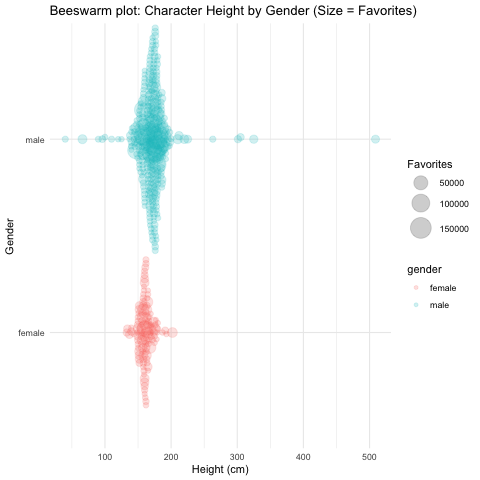

In [116]:
%%R -i gender

library(ggplot2)
library(ggbeeswarm)
library(ggimage)
library(dplyr)

df <- gender %>% select(
  name,
  favorites,
  gender,
  image,
  height = Height_cm
)


ggplot(df, aes(x = height, y = gender, color = gender, size = favorites)) +
  geom_point(position = position_beeswarm(), alpha = 0.2) +
  scale_size(range = c(2, 10)) +  # Adjust point size range here
  theme_minimal() +
  labs(
    x = "Height (cm)",
    y = "Gender",
    size = "Favorites",
    title = "Beeswarm plot: Character Height by Gender (Size = Favorites)"
  ) +
  




### WordCloud